In [1]:
import sys
sys.argv = ['']
from functools import reduce
import numpy as np
import pandas as pd
import argparse
import torch
import os
import datetime
import time
from random import uniform
from math import sqrt
from torch import nn
import csv
import json
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Below is the code for ZOEG implementation for training a calssifier nueral netwrok regarding the Robust oprimisation example.

In [42]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def save_dictionary_to_file(filename, dictionary):
    with open(filename, 'w') as file:
        json.dump(dictionary, file, cls=NpEncoder)


def save_dictionary_settings(filename, dictionary):
    for k, v in dictionary.items():
        if isinstance(v, np.int64):
            dictionary[k] = int(v)

    with open(filename, "w") as myfile:
        json.dump(dictionary, myfile)


def write_list_of_lists(filename, lists):
    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(lists)


def clear_file(file):
    with open(file, "w") as _:
        pass


def append_file(msg, file):
    with open(file, "a") as f:
        f.write(msg + '\n')

In [43]:
def get_total_parameters_for_layer(param):
    return reduce(lambda x, y: x * y, np.array(param.detach().shape))


def get_total_number_of_parameters(parameters):
    total_number_of_parameters = 0

    for param in parameters:
        if param.requires_grad:
            total_number_of_parameters += get_total_parameters_for_layer(param)

    return total_number_of_parameters


def add_to_parameters(parameters, random_direction):
    pos = 0

    for param in parameters:
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            param.data = param.detach() + random_direction[pos:pos + total_parameters_for_layer].view(param.shape)
            pos += total_parameters_for_layer

In [44]:
class Model(torch.nn.Module):

    def __init__(self, num_features, num_samples, regularization_lambda, device, hidden_size=50):
        super(Model, self).__init__()
        self.p = torch.tensor([1 / num_samples] * num_samples, requires_grad=True, dtype=torch.float32, device=device)
        self.regularization_lambda = regularization_lambda
        self.num_samples = num_samples

        self.hidden = nn.Linear(num_features, hidden_size)
        self.hidden_act = nn.LeakyReLU(negative_slope=0.1)
        self.out = nn.Linear(hidden_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        x = self.hidden_act(x)
        x = self.out(x)
        x = self.out_act(x)
        return x


def initialize_model(model, device, seed=42, divider=100):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            if len(param.shape) == 1:  # bias
                param.data = torch.zeros(param.shape, requires_grad=True, dtype=torch.float32, device=device).data
            else:
                param.data = ((torch.rand(total_parameters_for_layer, requires_grad=True, dtype=torch.float32,
                                          device=device) - 0.5) / divider).reshape(param.shape).data

In [45]:
EPS = 1e-12


def bce_loss(model, predictions, classes):
    """ Weighted cross entropy loss """
    loss = -((predictions + EPS).log() * classes + (1 - predictions + EPS).log() * (1 - classes))
    return torch.mean(loss.view(-1) * model.p)


def robustness_loss(model):
    return - model.regularization_lambda * torch.sum((model.p - 1 / model.num_samples) ** 2)


def total_loss(model, features, classes):
    predictions = model(features)
    return bce_loss(model, predictions, classes) + robustness_loss(model)

The ZO-EG algorithm is implemented below.

In [46]:
class ConvergedException(Exception):
    pass


def sample_gaussian_distribution(d,device):
    v = np.random.normal(0,1, size=d) 
    return torch.tensor(v, device=device, dtype=torch.float32)


class ZOEG:

    def __init__(self, parameters, mu=0.001, ssize=1e-6, device='cpu'):

        self.parameters = list(parameters)
        self.num_parameters = get_total_number_of_parameters(self.parameters)
        self.device = device

        self.mu = mu
        self.ssize1 = ssize
        self.ssize2 = ssize/2

    def step(self, loss_function, *args):
        previous_loss = loss_function(*args)

        u = sample_gaussian_distribution(self.num_parameters, self.device)
        add_to_parameters(self.parameters, self.mu*u)

        current_loss = loss_function(*args)

        add_to_parameters(self.parameters, -self.mu*u)
        g_const = (current_loss-previous_loss)/self.mu


        add_to_parameters(self.parameters, self.ssize1*g_const*u)


        previous_loss_bar = loss_function(*args)
        u_bar = sample_gaussian_distribution(self.num_parameters, self.device)
        add_to_parameters(self.parameters, self.mu*u_bar)

        current_loss_bar = loss_function(*args)

        add_to_parameters(self.parameters, -self.mu*u_bar)
        g_const_bar = (current_loss_bar-previous_loss_bar)/self.mu

        add_to_parameters(self.parameters, -self.ssize1*g_const*u)

        add_to_parameters(self.parameters, self.ssize2*g_const_bar*u_bar)

        new_loss = loss_function(*args)

        return new_loss.cpu().item(),g_const_bar*u_bar


In [47]:
def get_accuracy(predictions, classes):
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    acc=accuracy_score(classes, predictions)
    return acc

def accuracy_for_class(predictions, classes, class_value):
    # Filter true and predicted labels for the specified class
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    true_class = [classes[i] for i in range(len(classes)) if classes[i] == class_value]
    pred_class = [predictions[i] for i in range(len(predictions)) if classes[i] == class_value]

    # Calculate accuracy for the specified class
    correct_predictions = sum(1 for true, pred in zip(true_class, pred_class) if true == pred)
    total_samples = len(true_class)

    if total_samples == 0:
        return 0.0  # Avoid division by zero

    accuracy = correct_predictions / total_samples
    return accuracy

def run_robust():
    # Read data
    data = pd.read_csv(args.data_file, header=None)

    classes, features = np.array([[0] if val == 'M' else [1] for val in data.loc[:, 1].values],
                                 dtype=int), data.loc[:, 2:].values
    features_tensor = torch.tensor(features, dtype=torch.float32, requires_grad=False).to(args.device)
    classes_tensor = torch.tensor(classes, dtype=torch.float32, requires_grad=False).to(args.device)

    # # save results
    # if not os.path.exists(args.save_results_folder):
    #     if args.verbose:
    #         print('Creating', args.save_results_folder)
    #     os.makedirs(args.save_results_folder)

    # save_file = os.path.join(args.save_results_folder, args.save_results_file)
    # clear_file(save_file)
    
    Test_acc = np.zeros((args.num_epochs,args.num_folds))
    Train_acc = np.zeros((args.num_epochs,args.num_folds))
    Test_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Test_acc1 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc1 = np.zeros((args.num_epochs,args.num_folds))
    j=0
    kf = KFold(n_splits=args.num_folds, random_state=27, shuffle=True)
    kf.get_n_splits(features_tensor)
    ntime = []
    for train_index, test_index in kf.split(features_tensor):
        start = time.time()
        x_train, x_test = features_tensor[train_index], features_tensor[test_index]
        y_train, y_test = classes_tensor[train_index], classes_tensor[test_index]

        # Create model
        model = Model(x_train.shape[1], x_train.shape[0], args.reg_parameter, args.device, hidden_size=args.hidden_size)
        model.to(args.device)
        initialize_model(model, args.device, seed=42)

        ZOEG_max = ZOEG([model.p], mu = args.mu_x, ssize = args.h_x, device=args.device)
        ZOEG_min = ZOEG(model.parameters(), mu = args.mu_y, ssize = args.h_y, device=args.device)

        # minimize the negative as the maximization target
        negative_total_loss = lambda *x: - total_loss(*x)

        for epoch in range(args.num_epochs):

            try:
                 loss_d,g_x = ZOEG_max.step(negative_total_loss, model, x_train, y_train)
            except ConvergedException:
                pass

            try:
                loss_g,g_y = ZOEG_min.step(total_loss, model, x_train, y_train)
            except ConvergedException:
                pass

            predictions = model(x_train)
            Train_acc[epoch,j] = get_accuracy(predictions, y_train.numpy())
            Train_acc0[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=0)
            Train_acc1[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=1)

            predictions = model(x_test)
            Test_acc[epoch,j] = get_accuracy(predictions, y_test.numpy())
            Test_acc0[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=0)
            Test_acc1[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=1)
            # Temporary dump accuracies to the specified save file
            # if args.verbose and epoch % 200 == 0:
            #     predictions = model(x_train)
            #     train_acc = get_accuracy(predictions, y_train.numpy())
            #     predictions = model(x_test)
            #     test_acc = get_accuracy(predictions, y_test.numpy())
            #     res = "Epoch {:4d} train-acc {} test-acc {}".format(epoch, train_acc, test_acc)
            #     print(res)
                # for name, param in model.named_parameters():
                #     print(f"Parameter: {name}, Size: {param.size()}")
                #     print(param.data[:5])
                #     print("=" * 20)
                # print([model.p[0:5]])
            #append_file(res, save_file)
        j = j+1
        end = time.time()
        ntime.append(end-start)
    return Train_acc,Train_acc0,Train_acc1,Test_acc,Test_acc0,Test_acc1,np.array(ntime)



In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_file", type=str, default='wdbc.data')
    parser.add_argument("--hidden_size", type=int, default=50, help="Hidden size of the MLP")
    parser.add_argument("--num_folds", type=int, default=10)
    parser.add_argument("--device", type=str, default="cpu")

    ts = time.time()
    curr_datetime = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    folder = 'robust_results_' + curr_datetime + '/'
    parser.add_argument("--save_results_folder", type=str, default=folder)
    parser.add_argument("--save_results_file", type=str, default="results.txt")


    parser.add_argument("--mu_x", type=float, default=1e-5)
    parser.add_argument("--mu_y", type=float, default=1e-5)
    parser.add_argument("--h_x", type=float, default=1e-3)
    parser.add_argument("--h_y", type=float, default=1e-3)

    parser.add_argument("--reg_parameter", type=float, default=.05,
                        help="Regularization parameter for the robust optimization problem")
    parser.add_argument("--num_epochs", type=int, default=22001)
    parser.add_argument("--verbose", type=int, default=1)
    args = parser.parse_args()

    Train_acc,Train_acc0,Train_acc1,Test_acc,Test_acc0,Test_acc1,ntime=run_robust()

Saving the reults for later use.

In [ ]:
# np.save('Train_acc.npy', Train_acc)
# np.save('Train_acc0.npy', Train_acc0)
# np.save('Train_acc1.npy', Train_acc1)
# np.save('Test_acc.npy', Test_acc)
# np.save('Test_acc0.npy', Test_acc0)Y
# np.save('Test_acc1.npy', Test_acc1)
# np.save('ntime.npy', np.array(ntime))

Loading the results of RMM and DS. Note that the DS is implemented in the DR_NN2.ipynb file.

In [ ]:
# Train_acc = np.load('Train_acc.npy')
# Train_acc0 = np.load('Train_acc0.npy')
# Train_acc1 = np.load('Train_acc1.npy')
# Test_acc = np.load('Test_acc.npy')
# Test_acc0 = np.load('Test_acc0.npy')
# Test_acc1 = np.load('Test_acc1.npy')
# ntime = np.load('ntime.npy')

In [ ]:
# Train_acc_DR = np.load('Train_acc_DR.npy')
# Train_acc0_DR = np.load('Train_acc0_DR.npy')
# Train_acc1_DR = np.load('Train_acc1_DR.npy')
# Test_acc_DR = np.load('Test_acc_DR.npy')
# Test_acc0_DR = np.load('Test_acc0_DR.npy')
# Test_acc1_DR = np.load('Test_acc1_DR.npy')
# ntime2 = np.load('ntime2.npy')

Calculating the mean and standard deviation and plot them vs iterations and time for the accuracy of RMM and DS.

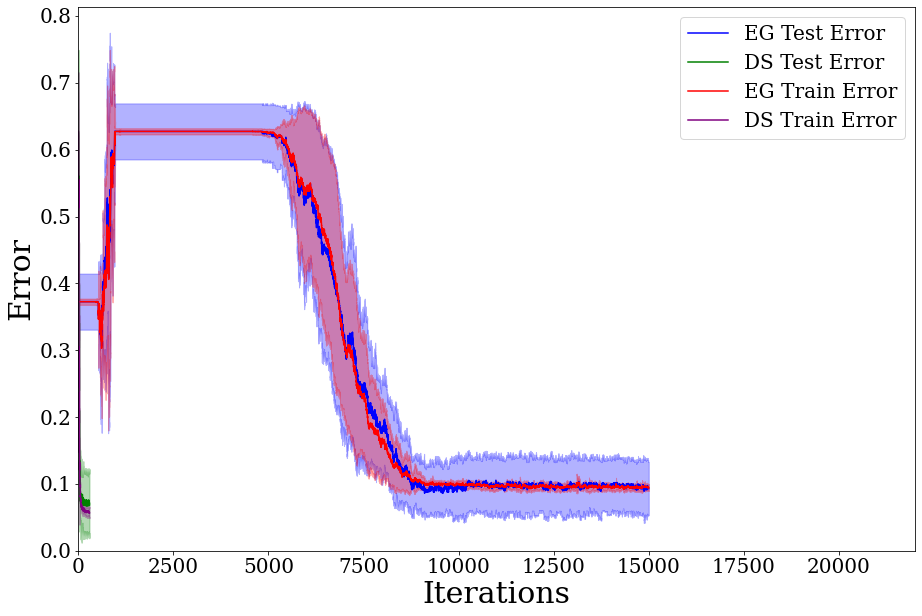

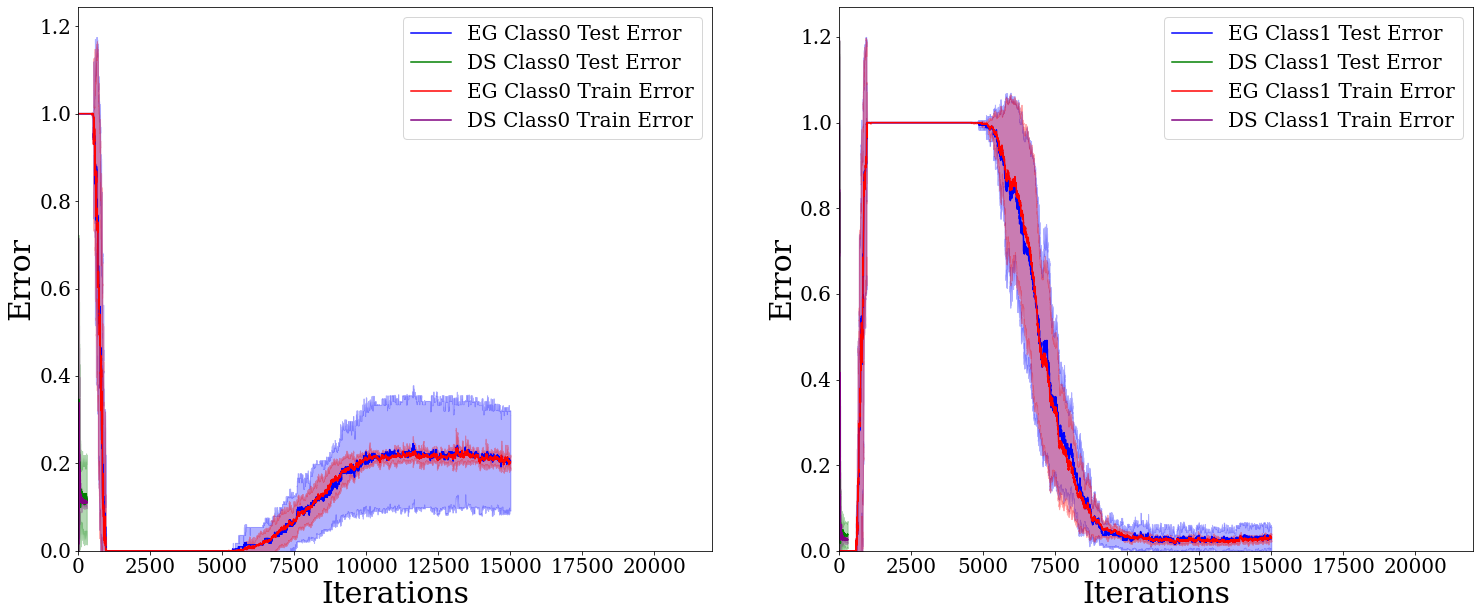

In [6]:
Train_error = 1-Train_acc
Train_error0 = 1-Train_acc0
Train_error1 = 1-Train_acc1
Test_error = 1-Test_acc
Test_error0 = 1-Test_acc0
Test_error1 = 1-Test_acc1

# Calculate mean and standard deviation along axis 1 (across runs)
mean_accuracy_test = np.mean(Test_error, axis=1)
std_dev_accuracy_test = np.std(Test_error, axis=1)
mean_accuracy_test0 = np.mean(Test_error0, axis=1)
std_dev_accuracy_test0 = np.std(Test_error0, axis=1)
mean_accuracy_test1 = np.mean(Test_error1, axis=1)
std_dev_accuracy_test1 = np.std(Test_error1, axis=1)

mean_accuracy_train = np.mean(Train_error, axis=1)
std_dev_accuracy_train = np.std(Train_error, axis=1)
mean_accuracy_train0 = np.mean(Train_error0, axis=1)
std_dev_accuracy_train0 = np.std(Train_error0, axis=1)
mean_accuracy_train1 = np.mean(Train_error1, axis=1)
std_dev_accuracy_train1 = np.std(Train_error1, axis=1)

Train_error_DR = 1-Train_acc_DR
Train_error0_DR = 1-Train_acc0_DR
Train_error1_DR = 1-Train_acc1_DR
Test_error_DR = 1-Test_acc_DR
Test_error0_DR = 1-Test_acc0_DR
Test_error1_DR = 1-Test_acc1_DR

# Calculate mean and standard deviation along axis 1 (across runs)
mean_accuracy_test_DR = np.mean(Test_error_DR, axis=1)
std_dev_accuracy_test_DR = np.std(Test_error_DR, axis=1)
mean_accuracy_test0_DR = np.mean(Test_error0_DR, axis=1)
std_dev_accuracy_test0_DR = np.std(Test_error0_DR, axis=1)
mean_accuracy_test1_DR = np.mean(Test_error1_DR, axis=1)
std_dev_accuracy_test1_DR = np.std(Test_error1_DR, axis=1)

mean_accuracy_train_DR = np.mean(Train_error_DR, axis=1)
std_dev_accuracy_train_DR = np.std(Train_error_DR, axis=1)
mean_accuracy_train0_DR = np.mean(Train_error0_DR, axis=1)
std_dev_accuracy_train0_DR = np.std(Train_error0_DR, axis=1)
mean_accuracy_train1_DR = np.mean(Train_error1_DR, axis=1)
std_dev_accuracy_train1_DR = np.std(Train_error1_DR, axis=1)

t = np.array(range(len(mean_accuracy_test)))
t1 = np.array(range(len(mean_accuracy_test_DR)))

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')


plt.plot(t,mean_accuracy_test, label='EG Test Error',color='blue')
plt.fill_between(t,
                 mean_accuracy_test - std_dev_accuracy_test,
                 mean_accuracy_test + std_dev_accuracy_test,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test_DR, label='DS Test Error',color='green')
plt.fill_between(t1,
                 mean_accuracy_test_DR - std_dev_accuracy_test_DR,
                 mean_accuracy_test_DR + std_dev_accuracy_test_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train, label='EG Train Error',color='red')
plt.fill_between(t,
                 mean_accuracy_train - std_dev_accuracy_train,
                 mean_accuracy_train + std_dev_accuracy_train,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train_DR, label='DS Train Error',color='purple')
plt.fill_between(t1,
                 mean_accuracy_train_DR - std_dev_accuracy_train_DR,
                 mean_accuracy_train_DR + std_dev_accuracy_train_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.xlim(0,22001)
plt.legend(loc='best', prop=font1)
plt.savefig('Pics/Both.pdf', format='pdf')
plt.show()

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(t,mean_accuracy_test0, label='EG Class0 Test Error',color='blue')

plt.fill_between(t,
                 mean_accuracy_test0 - std_dev_accuracy_test0,
                 mean_accuracy_test0 + std_dev_accuracy_test0,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test0_DR, label='DS Class0 Test Error',color='green')

plt.fill_between(t1,
                 mean_accuracy_test0_DR - std_dev_accuracy_test0_DR,
                 mean_accuracy_test0_DR + std_dev_accuracy_test0_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train0, label='EG Class0 Train Error',color='red')

plt.fill_between(t,
                 mean_accuracy_train0 - std_dev_accuracy_train0,
                 mean_accuracy_train0 + std_dev_accuracy_train0,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train0_DR, label='DS Class0 Train Error',color='purple')

plt.fill_between(t1,
                 mean_accuracy_train0_DR - std_dev_accuracy_train0_DR,
                 mean_accuracy_train0_DR + std_dev_accuracy_train0_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.xlim(0,22001)
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(t,mean_accuracy_test1, label='EG Class1 Test Error',color='blue')
plt.fill_between(t,
                 mean_accuracy_test1 - std_dev_accuracy_test1,
                 mean_accuracy_test1 + std_dev_accuracy_test1,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test1_DR, label='DS Class1 Test Error',color='green')
plt.fill_between(t1,
                 mean_accuracy_test1_DR - std_dev_accuracy_test1_DR,
                 mean_accuracy_test1_DR + std_dev_accuracy_test1_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train1, label='EG Class1 Train Error',color='red')
plt.fill_between(t,
                 mean_accuracy_train1 - std_dev_accuracy_train1,
                 mean_accuracy_train1 + std_dev_accuracy_train1,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train1_DR, label='DS Class1 Train Error',color='purple')
plt.fill_between(t1,
                 mean_accuracy_train1_DR - std_dev_accuracy_train1_DR,
                 mean_accuracy_train1_DR + std_dev_accuracy_train1_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.xlim(0,22001)
plt.legend(loc='upper right', prop=font1)
plt.savefig('Pics/class10.pdf', format='pdf')
plt.show()

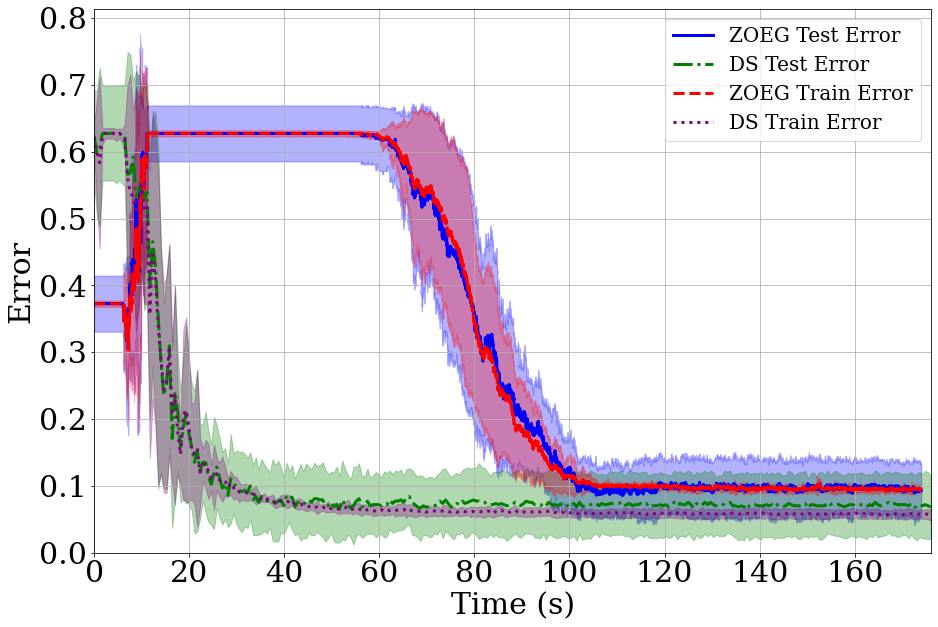

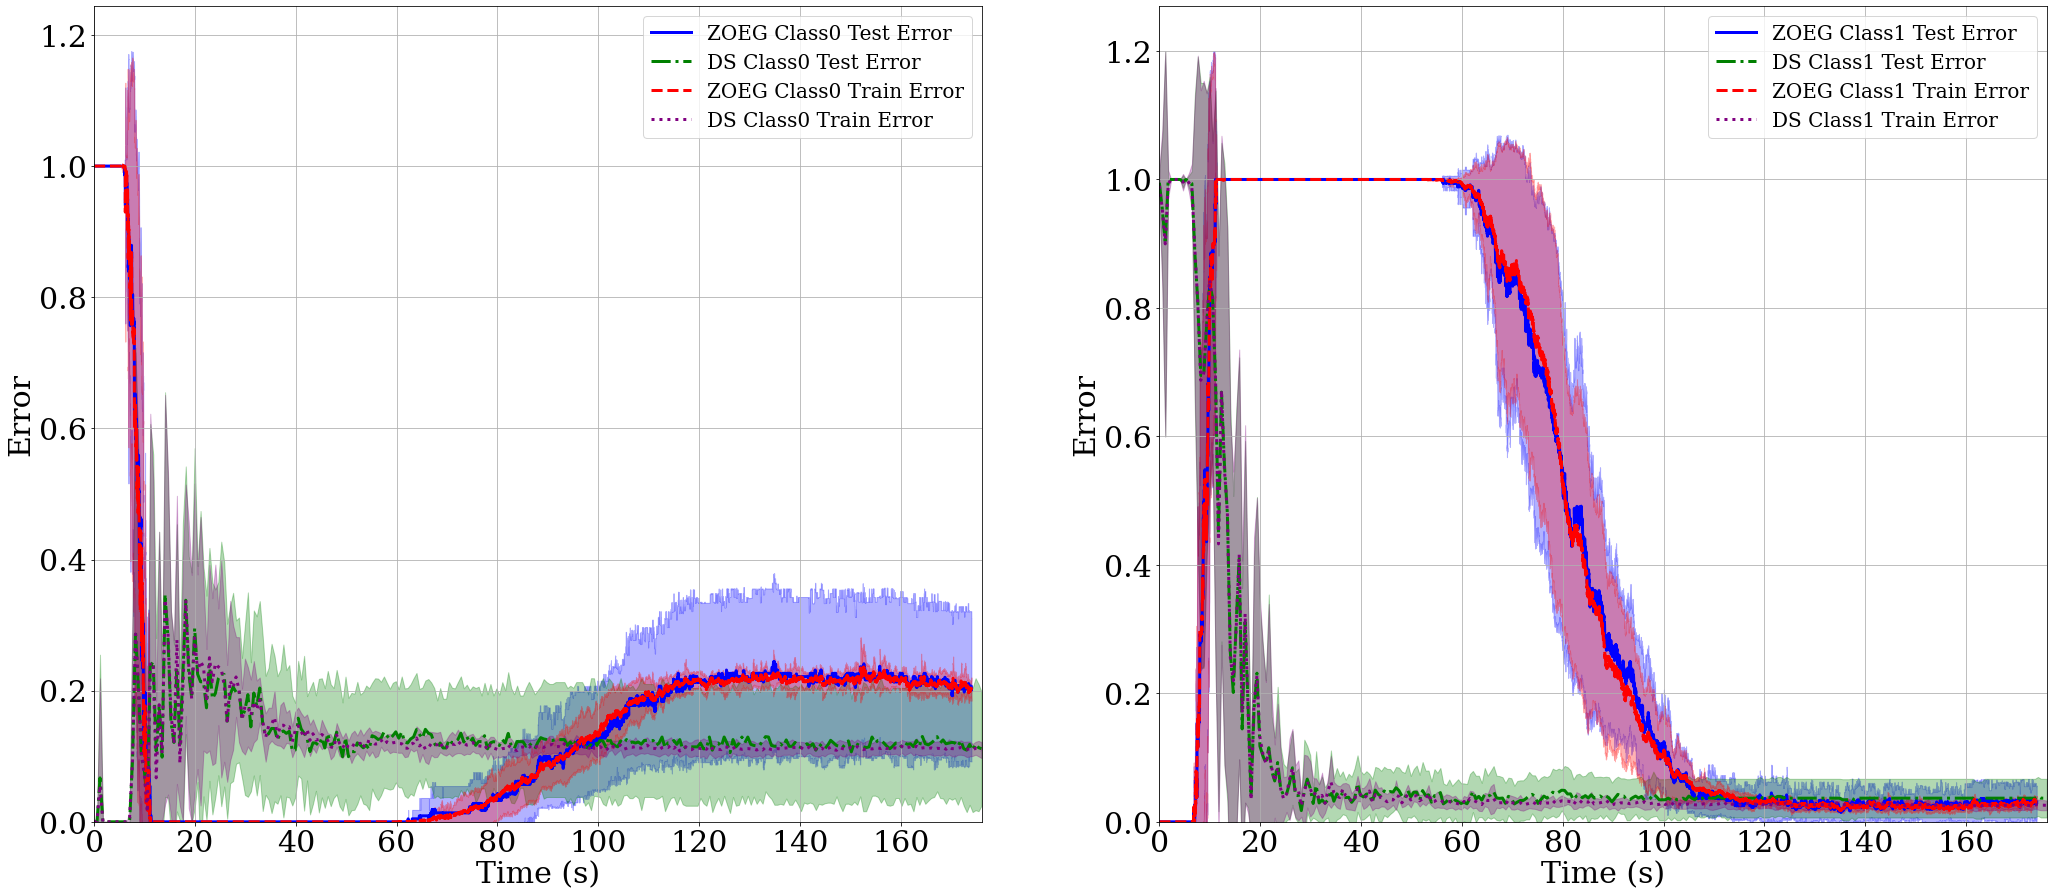

In [7]:
ntime_avg = np.mean(ntime)
ntime_avg2 = np.mean(ntime2)
t = np.linspace(0,int(ntime_avg),len(mean_accuracy_test))
t1 = np.linspace(0,int(ntime_avg2),len(mean_accuracy_test_DR))

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')


plt.plot(t,mean_accuracy_test,'-', label='ZOEG Test Error',color='blue',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_test - std_dev_accuracy_test,
                 mean_accuracy_test + std_dev_accuracy_test,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test_DR,'-.', label='DS Test Error',color='green',linewidth=3)
plt.fill_between(t1,
                 mean_accuracy_test_DR - std_dev_accuracy_test_DR,
                 mean_accuracy_test_DR + std_dev_accuracy_test_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train,'--', label='ZOEG Train Error',color='red',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_train - std_dev_accuracy_train,
                 mean_accuracy_train + std_dev_accuracy_train,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train_DR,':', label='DS Train Error',color='purple',linewidth=3)
plt.fill_between(t1,
                 mean_accuracy_train_DR - std_dev_accuracy_train_DR,
                 mean_accuracy_train_DR + std_dev_accuracy_train_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.xlim(0,ntime_avg2)
plt.grid('on')
plt.ylim(0,)
plt.legend(loc='best', prop=font1)
plt.savefig('Pics/Both_time.pdf', format='pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(35,15))

plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')

plt.plot(t,mean_accuracy_test0,'-', label='ZOEG Class0 Test Error',color='blue',linewidth=3)

plt.fill_between(t,
                 mean_accuracy_test0 - std_dev_accuracy_test0,
                 mean_accuracy_test0 + std_dev_accuracy_test0,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test0_DR,'-.', label='DS Class0 Test Error',color='green',linewidth=3)

plt.fill_between(t1,
                 mean_accuracy_test0_DR - std_dev_accuracy_test0_DR,
                 mean_accuracy_test0_DR + std_dev_accuracy_test0_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train0,'--', label='ZOEG Class0 Train Error',color='red',linewidth=3)

plt.fill_between(t,
                 mean_accuracy_train0 - std_dev_accuracy_train0,
                 mean_accuracy_train0 + std_dev_accuracy_train0,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train0_DR,':', label='DS Class0 Train Error',color='purple',linewidth=3)

plt.fill_between(t1,
                 mean_accuracy_train0_DR - std_dev_accuracy_train0_DR,
                 mean_accuracy_train0_DR + std_dev_accuracy_train0_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.xlim(0,ntime_avg2)
plt.ylim(0,)
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')

plt.plot(t,mean_accuracy_test1,'-', label='ZOEG Class1 Test Error',color='blue',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_test1 - std_dev_accuracy_test1,
                 mean_accuracy_test1 + std_dev_accuracy_test1,
                 alpha=0.3,color='blue')

plt.plot(t1,mean_accuracy_test1_DR,'-.', label='DS Class1 Test Error',color='green',linewidth=3)
plt.fill_between(t1,
                 mean_accuracy_test1_DR - std_dev_accuracy_test1_DR,
                 mean_accuracy_test1_DR + std_dev_accuracy_test1_DR,
                 alpha=0.3,color='green')

plt.plot(t,mean_accuracy_train1,'--', label='ZOEG Class1 Train Error',color='red',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_train1 - std_dev_accuracy_train1,
                 mean_accuracy_train1 + std_dev_accuracy_train1,
                 alpha=0.3,color='red')

plt.plot(t1,mean_accuracy_train1_DR,':', label='DS Class1 Train Error',color='purple',linewidth=3)
plt.fill_between(t1,
                 mean_accuracy_train1_DR - std_dev_accuracy_train1_DR,
                 mean_accuracy_train1_DR + std_dev_accuracy_train1_DR,
                 alpha=0.3,color='purple')

plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.xlim(0,ntime_avg2)
plt.ylim(0,)
plt.grid('on')
plt.legend(loc='upper right', prop=font1)
plt.savefig('Pics/class10_time.pdf', format='pdf',bbox_inches='tight')
plt.show()

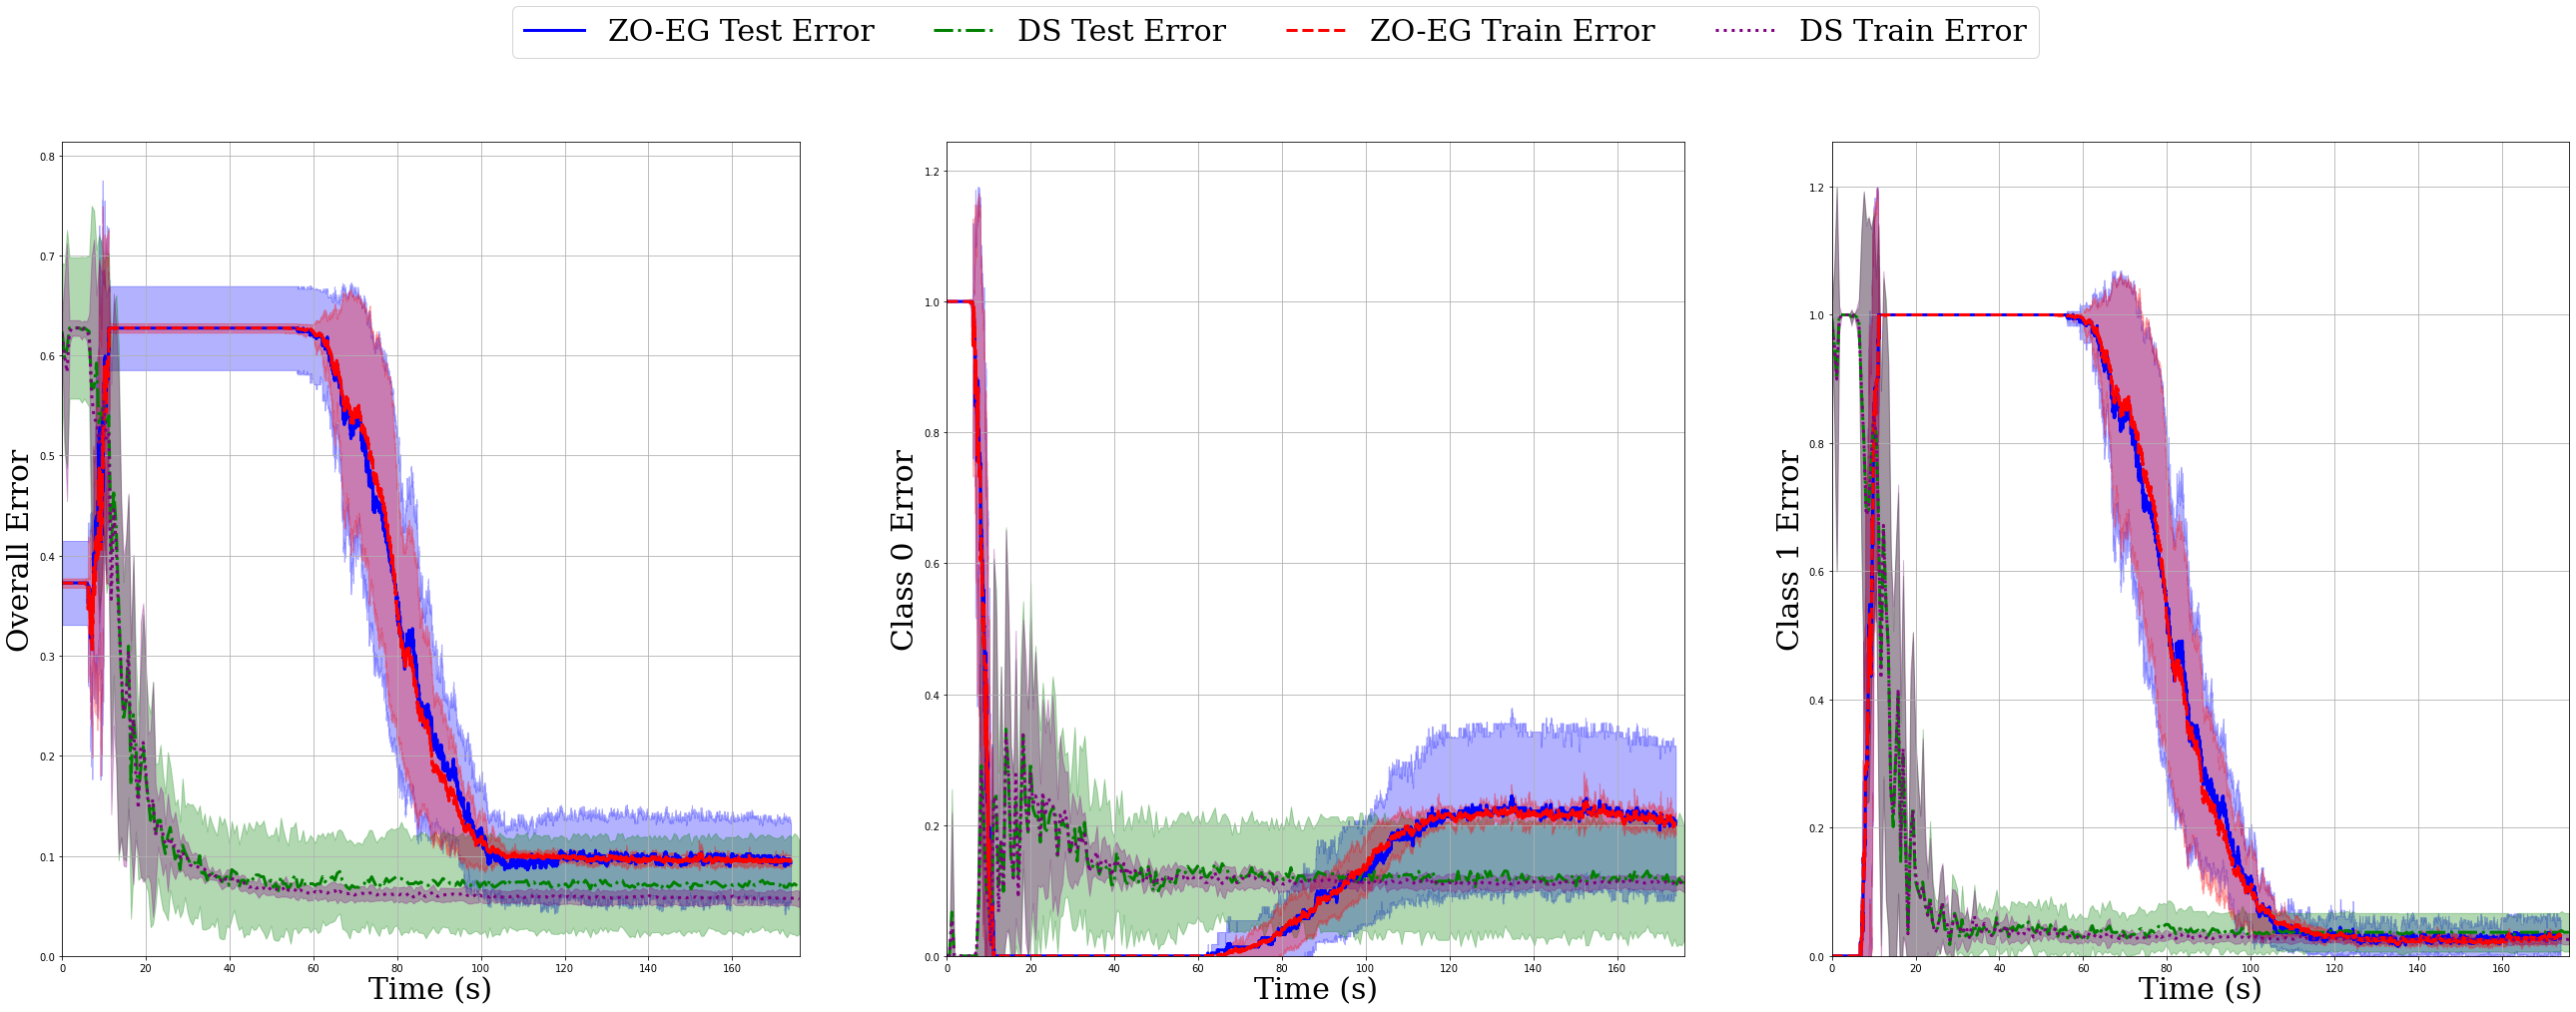

In [8]:

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 30}
plt.figure(figsize=(45, 15))


ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)


plot_params = [
    {'data': (t, mean_accuracy_test, std_dev_accuracy_test), 'style': '-', 'label': 'ZO-EG Test Error', 'color': 'blue'},
    {'data': (t1, mean_accuracy_test_DR, std_dev_accuracy_test_DR), 'style': '-.', 'label': 'DS Test Error', 'color': 'green'},
    {'data': (t, mean_accuracy_train, std_dev_accuracy_train), 'style': '--', 'label': 'ZO-EG Train Error', 'color': 'red'},
    {'data': (t1, mean_accuracy_train_DR, std_dev_accuracy_train_DR), 'style': ':', 'label': 'DS Train Error', 'color': 'purple'}
]


def plot_with_fill(ax, t, mean, std_dev, style, label, color):
    ax.plot(t, mean, style, label=label, color=color, linewidth=3)
    ax.fill_between(t, mean - std_dev, mean + std_dev, alpha=0.3, color=color)


for p in plot_params:
    plot_with_fill(ax1, *p['data'], p['style'], p['label'], p['color'])
ax1.set_xlabel('Time (s)', fontdict=font)
ax1.set_ylabel('Overall Error', fontdict=font)
ax1.set_xlim(0, ntime_avg2)
ax1.set_ylim(0,)
ax1.grid(True)

plot_params[0]['data'] = (t, mean_accuracy_test0, std_dev_accuracy_test0)
plot_params[1]['data'] = (t1, mean_accuracy_test0_DR, std_dev_accuracy_test0_DR)
plot_params[2]['data'] = (t, mean_accuracy_train0, std_dev_accuracy_train0)
plot_params[3]['data'] = (t1, mean_accuracy_train0_DR, std_dev_accuracy_train0_DR)

for p in plot_params:
    plot_with_fill(ax2, *p['data'], p['style'], p['label'], p['color'])
ax2.set_xlabel('Time (s)', fontdict=font)
ax2.set_ylabel('Class 0 Error', fontdict=font)
ax2.set_xlim(0, ntime_avg2)
ax2.set_ylim(0,)
ax2.grid(True)


plot_params[0]['data'] = (t, mean_accuracy_test1, std_dev_accuracy_test1)
plot_params[1]['data'] = (t1, mean_accuracy_test1_DR, std_dev_accuracy_test1_DR)
plot_params[2]['data'] = (t, mean_accuracy_train1, std_dev_accuracy_train1)
plot_params[3]['data'] = (t1, mean_accuracy_train1_DR, std_dev_accuracy_train1_DR)

for p in plot_params:
    plot_with_fill(ax3, *p['data'], p['style'], p['label'], p['color'])
ax3.set_xlabel('Time (s)', fontdict=font)
ax3.set_ylabel('Class 1 Error', fontdict=font)
ax3.set_xlim(0, ntime_avg2)
ax3.set_ylim(0,)
ax3.grid(True)


handles, labels = ax1.get_legend_handles_labels()
fig = plt.gcf()
fig.legend(handles, labels, loc='upper center', prop=font1, ncol=4, bbox_to_anchor=(0.5, 1.02))

plt.savefig('Pics/allfigs.pdf', format='pdf', bbox_inches='tight')
plt.show()
